aggiungere i dati che servono

In [49]:
from collections import namedtuple
from random import choice
from tqdm.auto import tqdm
import numpy as np
import heapq
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Image as IPImage
from io import BytesIO

In [35]:
PUZZLE_DIM = 3
action = namedtuple('Action', ['pos1', 'pos2'])

In [36]:
def available_actions(state: np.ndarray) -> list['Action']:
    x, y = [int(_[0]) for _ in np.where(state == 0)]
    actions = list()
    if x > 0:
        actions.append(action((x, y), (x - 1, y)))
    if x < PUZZLE_DIM - 1:
        actions.append(action((x, y), (x + 1, y)))
    if y > 0:
        actions.append(action((x, y), (x, y - 1)))
    if y < PUZZLE_DIM - 1:
        actions.append(action((x, y), (x, y + 1)))
    return actions

def do_action(state: np.ndarray, action: 'Action') -> np.ndarray:
    new_state = state.copy()
    new_state[action.pos1], new_state[action.pos2] = new_state[action.pos2], new_state[action.pos1]
    return new_state

In [50]:
def print_puzzle(state: np.ndarray):
    border = "+" + "---+" * PUZZLE_DIM
    for row in state:
        print(border)
        row_str = "|".join(f" {val if val != 0 else ' '} " for val in row)
        print(f"|{row_str}|")
    print(border)  # Stampa il bordo finale

def print_solution(solution_path: list[np.ndarray]):
    print("\nSolution Path:")
    for step, state in enumerate(solution_path):
        print(f"\nStep {step}:")
        print_puzzle(state)
def draw_puzzle_image(state: np.ndarray, cell_size: int = 100) -> Image:
    """Crea un'immagine del puzzle per uno stato dato."""
    img_size = PUZZLE_DIM * cell_size
    img = Image.new("RGB", (img_size, img_size), "white")
    draw = ImageDraw.Draw(img)

    # Usa un font predefinito o specifica un font .ttf
    try:
        font = ImageFont.truetype("arial.ttf", size=30)  # Modifica il percorso se necessario
    except IOError:
        font = ImageFont.load_default()  # Usa un font predefinito se Arial non è disponibile

    # Disegna la griglia e i numeri
    for i in range(PUZZLE_DIM):
        for j in range(PUZZLE_DIM):
            x0, y0 = j * cell_size, i * cell_size
            x1, y1 = x0 + cell_size, y0 + cell_size

            # Disegna la cella
            draw.rectangle([x0, y0, x1, y1], outline="black", width=2)

            # Scrivi il numero al centro della cella (salta lo 0)
            if state[i, j] != 0:
                text = str(state[i, j])
                bbox = font.getbbox(text)  # Ottieni il riquadro di delimitazione del testo
                text_width = bbox[2] - bbox[0]
                text_height = bbox[3] - bbox[1]
                text_x = x0 + (cell_size - text_width) // 2
                text_y = y0 + (cell_size - text_height) // 2
                draw.text((text_x, text_y), text, fill="black", font=font)

    return img


def create_solution_gif(solution_path: list[np.ndarray], filename: str = "solution.gif", duration: int = 500):
    """Crea una GIF animata dalla soluzione."""
    frames = [draw_puzzle_image(state) for state in solution_path]
    frames[0].save(
        filename,
        save_all=True,
        append_images=frames[1:],
        duration=duration,
        loop=0
    )
    print(f"GIF salvata come {filename}")

def display_solution_gif(solution_path: list[np.ndarray], duration: int = 500):
    """Crea e mostra una GIF animata della soluzione direttamente nel notebook."""
    frames = [draw_puzzle_image(state) for state in solution_path]

    # Salva la GIF in memoria
    gif_buffer = BytesIO()
    frames[0].save(
        gif_buffer,
        format="GIF",
        save_all=True,
        append_images=frames[1:],
        duration=duration,
        loop=0
    )
    gif_buffer.seek(0)  # Torna all'inizio del buffer

    # Mostra la GIF direttamente nel notebook
    display(IPImage(data=gif_buffer.getvalue(), format="gif"))


In [38]:
def manhattan_distance(state: np.ndarray) -> int:
    distance = 0
    for x in range(PUZZLE_DIM):
        for y in range(PUZZLE_DIM):
            value = state[x, y]
            if value == 0:
                continue
            target_x = (value - 1) // PUZZLE_DIM
            target_y = (value - 1) % PUZZLE_DIM
            distance += abs(x - target_x) + abs(y - target_y)
    return distance

def state_to_tuple(state: np.ndarray) -> tuple:
    return tuple(state.flatten())

def a_star(start: np.ndarray) -> tuple[list[np.ndarray], int]:
    goal = np.array([i for i in range(1, PUZZLE_DIM**2)] + [0]).reshape((PUZZLE_DIM, PUZZLE_DIM))
    goal_tuple = state_to_tuple(goal)
    start_tuple = state_to_tuple(start)
    
    open_set = []
    heapq.heappush(open_set, (0, start_tuple))
    came_from = {}
    g_score = {start_tuple: 0}
    f_score = {start_tuple: manhattan_distance(start)}
    total_evaluated = 0

    while open_set:
        _, current_tuple = heapq.heappop(open_set)
        current = np.array(current_tuple).reshape((PUZZLE_DIM, PUZZLE_DIM))
        
        if current_tuple == goal_tuple:
            path = []
            while current_tuple in came_from:
                path.append(np.array(current_tuple).reshape((PUZZLE_DIM, PUZZLE_DIM)))
                current_tuple = came_from[current_tuple]
            path.append(start)
            return path[::-1], total_evaluated

        total_evaluated += 1
        for action in available_actions(current):
            neighbor = do_action(current, action)
            neighbor_tuple = state_to_tuple(neighbor)
            tentative_g_score = g_score[current_tuple] + 1

            if neighbor_tuple not in g_score or tentative_g_score < g_score[neighbor_tuple]:
                came_from[neighbor_tuple] = current_tuple
                g_score[neighbor_tuple] = tentative_g_score
                f_score[neighbor_tuple] = tentative_g_score + manhattan_distance(neighbor)
                heapq.heappush(open_set, (f_score[neighbor_tuple], neighbor_tuple))
                
    return None, total_evaluated  # Restituisce None per la soluzione e il numero di stati valutati


In [39]:
class SMAStarNode:
    def __init__(self, state, g_cost, parent=None):
        self.state = state
        self.state_tuple = state_to_tuple(state)
        self.g_cost = g_cost  # costo accumulato per raggiungere questo nodo
        self.parent = parent  # riferimento al nodo predecessore
        self.h_cost = manhattan_distance(state)  # euristica
        self.f_cost = self.g_cost + self.h_cost  # costo totale stimato

    def __lt__(self, other):
        return self.f_cost < other.f_cost

def reconstruct_path(node):
    path = []
    while node:
        path.append(node.state)
        node = node.parent
    return path[::-1]

def sma_star(start: np.ndarray, memory_limit: int) -> list[np.ndarray]:
    goal = np.array([i for i in range(1, PUZZLE_DIM**2)] + [0]).reshape((PUZZLE_DIM, PUZZLE_DIM))
    goal_tuple = state_to_tuple(goal)
    
    open_set = []
    start_node = SMAStarNode(start, g_cost=0)
    heapq.heappush(open_set, start_node)
    
    visited = {start_node.state_tuple: start_node}

    while open_set:
        if len(open_set) > memory_limit:
            # Rimuove il nodo meno promettente (con f_cost più alto)
            worst_node = max(open_set, key=lambda n: n.f_cost)
            open_set.remove(worst_node)
            # Propaga il f_cost al nodo genitore se necessario
            if worst_node.parent:
                worst_node.parent.f_cost = max(worst_node.parent.f_cost, worst_node.f_cost)
            heapq.heapify(open_set)

        current_node = heapq.heappop(open_set)

        # Controllo se abbiamo raggiunto lo stato obiettivo
        if current_node.state_tuple == goal_tuple:
            return reconstruct_path(current_node)

        # Espande i nodi vicini
        for action in available_actions(current_node.state):
            neighbor_state = do_action(current_node.state, action)
            neighbor_tuple = state_to_tuple(neighbor_state)
            g_cost = current_node.g_cost + 1  # Ogni mossa costa 1

            if neighbor_tuple in visited:
                neighbor_node = visited[neighbor_tuple]
                if g_cost < neighbor_node.g_cost:
                    neighbor_node.g_cost = g_cost
                    neighbor_node.f_cost = g_cost + neighbor_node.h_cost
                    neighbor_node.parent = current_node
            else:
                neighbor_node = SMAStarNode(neighbor_state, g_cost, parent=current_node)
                visited[neighbor_tuple] = neighbor_node
                heapq.heappush(open_set, neighbor_node)

    return None


In [40]:
RANDOMIZE_STEPS = 100_000
state = np.array([i for i in range(1, PUZZLE_DIM**2)] + [0]).reshape((PUZZLE_DIM, PUZZLE_DIM))
for r in tqdm(range(RANDOMIZE_STEPS), desc='Randomizing'):
    state = do_action(state, choice(available_actions(state)))
None

Randomizing:   0%|          | 0/100000 [00:00<?, ?it/s]

In [41]:
# Esegui l'algoritmo A*
solution_path, total_evaluated = a_star(state)
if solution_path:
    quality = len(solution_path) - 1
    print_solution(solution_path)
    print(f"Solution found in {quality} steps!")
    print(f"Total actions evaluated: {total_evaluated}")
    print(f"Efficiency (Quality vs Cost): {quality / total_evaluated:.4f}")
else:
    print("No solution found.")


Solution Path:

Step 0:
+---+---+---+
| 5 | 8 | 6 |
+---+---+---+
| 3 |   | 2 |
+---+---+---+
| 1 | 7 | 4 |
+---+---+---+

Step 1:
+---+---+---+
| 5 |   | 6 |
+---+---+---+
| 3 | 8 | 2 |
+---+---+---+
| 1 | 7 | 4 |
+---+---+---+

Step 2:
+---+---+---+
|   | 5 | 6 |
+---+---+---+
| 3 | 8 | 2 |
+---+---+---+
| 1 | 7 | 4 |
+---+---+---+

Step 3:
+---+---+---+
| 3 | 5 | 6 |
+---+---+---+
|   | 8 | 2 |
+---+---+---+
| 1 | 7 | 4 |
+---+---+---+

Step 4:
+---+---+---+
| 3 | 5 | 6 |
+---+---+---+
| 1 | 8 | 2 |
+---+---+---+
|   | 7 | 4 |
+---+---+---+

Step 5:
+---+---+---+
| 3 | 5 | 6 |
+---+---+---+
| 1 | 8 | 2 |
+---+---+---+
| 7 |   | 4 |
+---+---+---+

Step 6:
+---+---+---+
| 3 | 5 | 6 |
+---+---+---+
| 1 |   | 2 |
+---+---+---+
| 7 | 8 | 4 |
+---+---+---+

Step 7:
+---+---+---+
| 3 | 5 | 6 |
+---+---+---+
| 1 | 2 |   |
+---+---+---+
| 7 | 8 | 4 |
+---+---+---+

Step 8:
+---+---+---+
| 3 | 5 | 6 |
+---+---+---+
| 1 | 2 | 4 |
+---+---+---+
| 7 | 8 |   |
+---+---+---+

Step 9:
+---+---+---

Solution found in 24 steps!
Total actions evaluated: 1097
Efficiency (Quality vs Cost): 0.0219


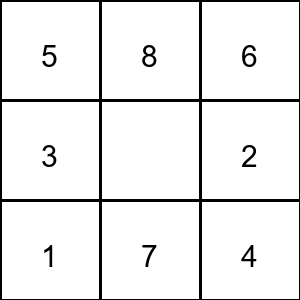

In [52]:
solution_path, total_evaluated = a_star(state)

if solution_path:
    quality = len(solution_path) - 1
    print(f"Solution found in {quality} steps!")
    print(f"Total actions evaluated: {total_evaluated}")
    print(f"Efficiency (Quality vs Cost): {quality / total_evaluated:.4f}")
    display_solution_gif(solution_path, duration=700)
else:
    print("No solution found.")


In [9]:
# Esegui l'algoritmo SMA* con un limite di memoria
MEMORY_LIMIT = 10 # Definire un limite di memoria
solution_path = sma_star(state, MEMORY_LIMIT)

if solution_path:
    print(f"Solution found in {len(solution_path) - 1} steps!")
    for step, s in enumerate(solution_path):
        print(f"Step {step}:\n{s}")
else:
    print("No solution found within memory limit.")

Solution found in 148 steps!
Step 0:
[[ 6 15 11  2]
 [10  7 12  5]
 [ 0  9  1  4]
 [ 3 14  8 13]]
Step 1:
[[ 6 15 11  2]
 [10  7 12  5]
 [ 9  0  1  4]
 [ 3 14  8 13]]
Step 2:
[[ 6 15 11  2]
 [10  7 12  5]
 [ 9  1  0  4]
 [ 3 14  8 13]]
Step 3:
[[ 6 15 11  2]
 [10  7  0  5]
 [ 9  1 12  4]
 [ 3 14  8 13]]
Step 4:
[[ 6 15  0  2]
 [10  7 11  5]
 [ 9  1 12  4]
 [ 3 14  8 13]]
Step 5:
[[ 6 15  2  0]
 [10  7 11  5]
 [ 9  1 12  4]
 [ 3 14  8 13]]
Step 6:
[[ 6 15  2  5]
 [10  7 11  0]
 [ 9  1 12  4]
 [ 3 14  8 13]]
Step 7:
[[ 6 15  2  5]
 [10  7 11  4]
 [ 9  1 12  0]
 [ 3 14  8 13]]
Step 8:
[[ 6 15  2  5]
 [10  7 11  4]
 [ 9  1  0 12]
 [ 3 14  8 13]]
Step 9:
[[ 6 15  2  5]
 [10  7  0  4]
 [ 9  1 11 12]
 [ 3 14  8 13]]
Step 10:
[[ 6 15  2  5]
 [10  0  7  4]
 [ 9  1 11 12]
 [ 3 14  8 13]]
Step 11:
[[ 6  0  2  5]
 [10 15  7  4]
 [ 9  1 11 12]
 [ 3 14  8 13]]
Step 12:
[[ 6  2  0  5]
 [10 15  7  4]
 [ 9  1 11 12]
 [ 3 14  8 13]]
Step 13:
[[ 6  2  7  5]
 [10 15  0  4]
 [ 9  1 11 12]
 [ 3 14  8 13]]
S